**Paddy Doctor**

#Import data and libraries

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# import librairies
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0

!pip install tensorflow-addons
!pip install -q -U keras-tuner
import tensorflow_addons as tfa
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.0 MB/s 
     |████████████████████████████████| 133 kB 14.1 MB/s 


##data exploration

In [ ]:
df_meta = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/paddy/train.csv")
df_meta.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [3]:
train_path = "/content/drive/MyDrive/Colab Notebooks/paddy/train_images"
test_path = "/content/drive/MyDrive/Colab Notebooks/paddy/test_images"

In [4]:
disease_list = os.listdir(train_path)
n_classes = len(disease_list)
print(disease_list)
print("Total diseases number:", n_classes)

['brown_spot', 'downy_mildew', 'tungro', 'hispa', 'normal', 'bacterial_leaf_streak', 'blast', 'dead_heart', 'bacterial_panicle_blight', 'bacterial_leaf_blight']
Total diseases number: 10


## Preprocessing

In [5]:
img_width = 224
img_height = 224
batch_size = 32

epochs = 100
epochs_ft = 200

nb_classes = 10

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    subset="training",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

valid_generator = train_datagen.flow_from_directory(
    train_path,
    subset="validation",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 5131 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


In [8]:
# images for prediction
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=["."],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [ ]:
# f1_score from tensorflow_addons
f1_tfa = tfa.metrics.F1Score(num_classes=n_classes, average="macro")

In [9]:
def plot_history(dict_history, first_score, second_score):

    """
creates two subplots for plotting 2 different metrics
called first_score and second_score against epoch number,
values obtained from the train and the validation datasets
are visualized
  """

    with plt.style.context("seaborn-whitegrid"):
        fig = plt.figure(figsize=(25, 10))

        # first suplot
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(
            dict_history.history["val_" + first_score], linestyle="--", color="orange"
        )
        plt.title(
            "Pre-trained EfficientNet_B0 on Paddy dataset " + first_score, fontsize=18
        )
        plt.ylabel(first_score)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")

        # second subplot
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(
            dict_history.history["val_" + second_score], linestyle="--", color="orange"
        )
        plt.title(
            "Pre-trained EfficientNet_B0 on Paddy dataset " + second_score, fontsize=18
        )
        plt.ylabel(second_score)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

In [11]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 10

# parameters for callback functions
es_patience = 10

#Model EfficientNetB0

In [12]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=es_patience,
    restore_best_weights=True,
    verbose=1,
)

In [15]:
# optimizer AdaBelief
opt = tfa.optimizers.AdaBelief(
    learning_rate=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
    rectify=True,
)

## tuning top layers

In [ ]:
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
num_classes = 10
model = build_model(num_classes=num_classes)

epochs = 80
hist = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    verbose=1,
    callbacks=[early_stp],
)

Epoch 1/80
161/161 - 121s - loss: 3.1733 - accuracy: 0.0941 - val_loss: 2.4045 - val_accuracy: 0.1141 - 121s/epoch - 750ms/step
Epoch 2/80
161/161 - 108s - loss: 2.7403 - accuracy: 0.1399 - val_loss: 2.1859 - val_accuracy: 0.2102 - 108s/epoch - 674ms/step
Epoch 3/80
161/161 - 108s - loss: 2.2571 - accuracy: 0.2438 - val_loss: 1.8716 - val_accuracy: 0.3391 - 108s/epoch - 672ms/step
Epoch 4/80
161/161 - 108s - loss: 1.9651 - accuracy: 0.3261 - val_loss: 1.6763 - val_accuracy: 0.4273 - 108s/epoch - 671ms/step
Epoch 5/80
161/161 - 108s - loss: 1.7334 - accuracy: 0.4062 - val_loss: 1.5108 - val_accuracy: 0.4812 - 108s/epoch - 670ms/step
Epoch 6/80
161/161 - 108s - loss: 1.6123 - accuracy: 0.4463 - val_loss: 1.3933 - val_accuracy: 0.5289 - 108s/epoch - 669ms/step
Epoch 7/80
161/161 - 107s - loss: 1.4728 - accuracy: 0.4980 - val_loss: 1.2942 - val_accuracy: 0.5453 - 107s/epoch - 668ms/step
Epoch 8/80
161/161 - 108s - loss: 1.3952 - accuracy: 0.5171 - val_loss: 1.2714 - val_accuracy: 0.5688 - 

In [ ]:
model.save(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_efficientnetb0_top_layers_builder"
)
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_efficientnetb0_top_layers_builder/assets
the model is saved


## tuning 20 last layers (last block + top layer)

In [16]:
# load model
model = load_model(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_efficientnetb0_top_layers_builder"
)
print("the model is saved")

the model is saved


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_8 (Normalization  (None, 224, 224, 3)  7          ['rescaling_8[0][0]']            
 )                                                                                                
                                                                                            

In [17]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen (top + last block)
    for layer in model.layers[-20:]:
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [18]:
efn = unfreeze_model(model)

In [19]:
# sans early stopping
history = efn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    verbose=1,
    #                   callbacks = [es]
)

Epoch 1/100
161/161 [==============================] - 2493s 15s/step - loss: 1.0048 - accuracy: 0.6642 - val_loss: 0.8943 - val_accuracy: 0.7070
Epoch 2/100
161/161 [==============================] - 95s 589ms/step - loss: 0.9614 - accuracy: 0.6743 - val_loss: 0.8979 - val_accuracy: 0.7055
Epoch 3/100
161/161 [==============================] - 95s 591ms/step - loss: 0.9618 - accuracy: 0.6741 - val_loss: 0.8195 - val_accuracy: 0.7219
Epoch 4/100
161/161 [==============================] - 96s 595ms/step - loss: 0.9169 - accuracy: 0.6962 - val_loss: 0.8571 - val_accuracy: 0.7211
Epoch 5/100
161/161 [==============================] - 96s 594ms/step - loss: 0.8324 - accuracy: 0.7168 - val_loss: 0.8496 - val_accuracy: 0.7188
Epoch 6/100
161/161 [==============================] - 95s 592ms/step - loss: 0.8064 - accuracy: 0.7353 - val_loss: 0.7424 - val_accuracy: 0.7516
Epoch 7/100
161/161 [==============================] - 94s 587ms/step - loss: 0.7335 - accuracy: 0.7611 - val_loss: 0.6048 -

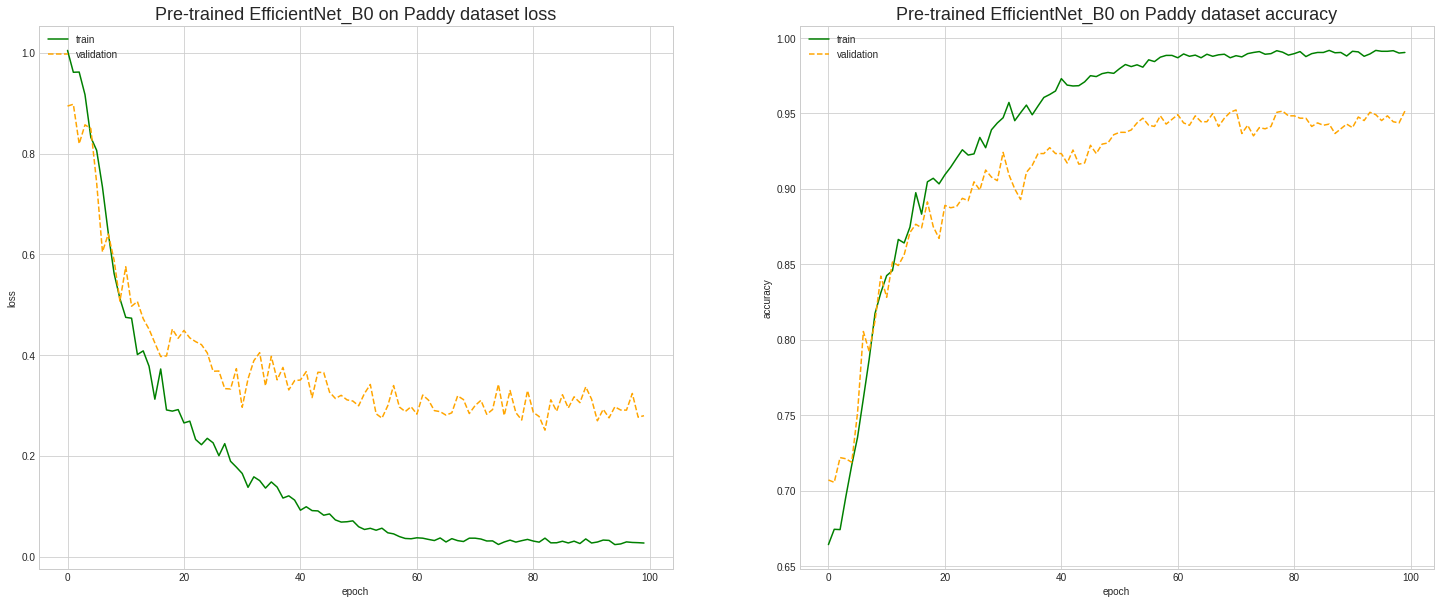

In [20]:
plot_history(dict_history=history, first_score="loss", second_score="accuracy")

In [21]:
efn.save(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_efficientnetb0_20_layers_3"
)
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_efficientnetb0_20_layers_3/assets
the model is saved


In [22]:
# predict sur test set avec resnet_26 layers
disease_pred = efn.predict(test_generator, batch_size=32,)

In [23]:
# formatting Kaggle submission
predicted_class_indices = np.argmax(disease_pred, axis=1)
print(set(predicted_class_indices))

inv_map = {v: k for k, v in train_generator.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [24]:
filenames = test_generator.filenames

results = pd.DataFrame({"image_id": filenames, "label": predictions})
results.image_id = results.image_id.str.replace("./", "")
results.to_csv("/content/drive/MyDrive/Colab Notebooks/submission8.csv", index=False)
results.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [ ]:
# avec early stopping
history = efn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    verbose=1,
    callbacks=[es],
)

Epoch 1/100
161/161 [==============================] - 1513s 9s/step - loss: 1.0062 - accuracy: 0.6609 - val_loss: 0.9216 - val_accuracy: 0.6938
Epoch 2/100
161/161 [==============================] - 95s 590ms/step - loss: 0.9909 - accuracy: 0.6679 - val_loss: 0.8744 - val_accuracy: 0.7016
Epoch 3/100
161/161 [==============================] - 94s 587ms/step - loss: 0.9657 - accuracy: 0.6706 - val_loss: 0.9045 - val_accuracy: 0.6969
Epoch 4/100
161/161 [==============================] - 94s 585ms/step - loss: 0.8903 - accuracy: 0.7026 - val_loss: 0.7902 - val_accuracy: 0.7437
Epoch 5/100
161/161 [==============================] - 94s 586ms/step - loss: 0.8501 - accuracy: 0.7114 - val_loss: 0.8415 - val_accuracy: 0.7164
Epoch 6/100
161/161 [==============================] - 94s 586ms/step - loss: 0.7978 - accuracy: 0.7324 - val_loss: 0.6055 - val_accuracy: 0.7984
Epoch 7/100
161/161 [==============================] - 94s 583ms/step - loss: 0.6981 - accuracy: 0.7655 - val_loss: 0.7433 - 

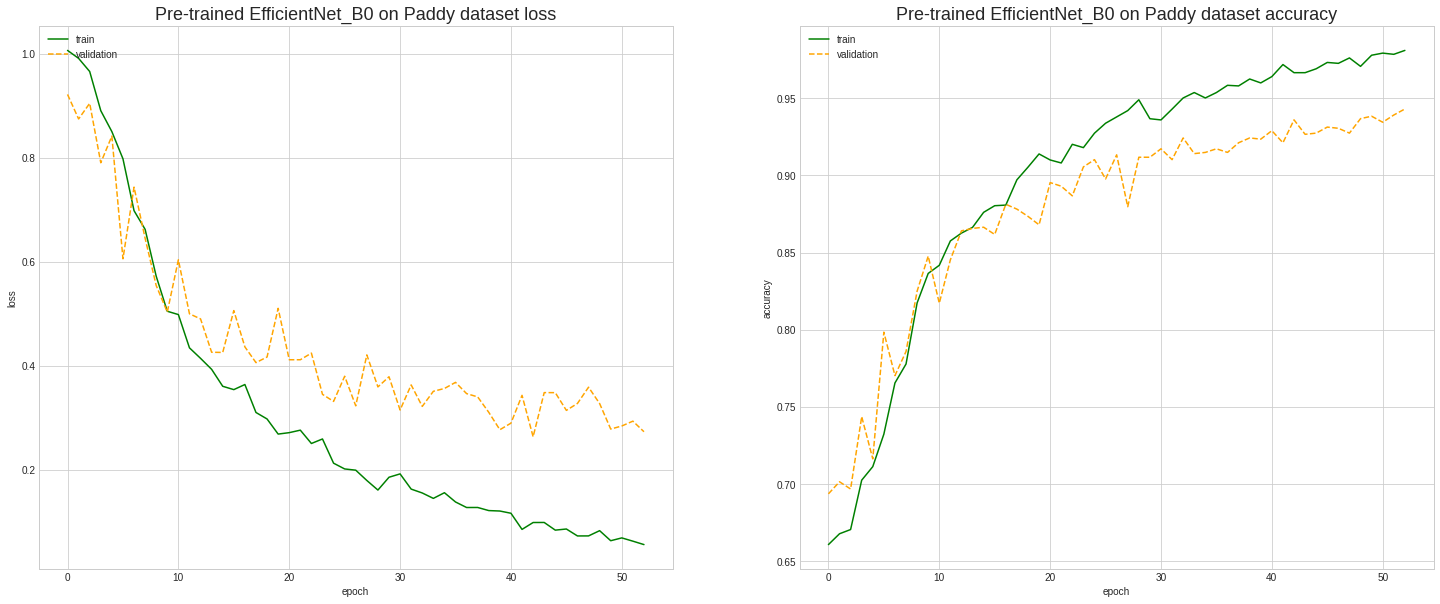

In [ ]:
plot_history(dict_history=history, first_score="loss", second_score="accuracy")

In [ ]:
efn.save(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_efficientnetb0_20_layers_2"
)
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_efficientnetb0_20_layers_2/assets
the model is saved


In [ ]:
# predict sur test set avec resnet_26 layers
disease_pred = efn.predict(test_generator, batch_size=32,)

In [ ]:
# formatting Kaggle submission
predicted_class_indices = np.argmax(disease_pred, axis=1)
print(set(predicted_class_indices))

inv_map = {v: k for k, v in train_generator.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({"image_id": filenames, "label": predictions})
results.image_id = results.image_id.str.replace("./", "")
results.to_csv("/content/drive/MyDrive/Colab Notebooks/submission6.csv", index=False)
results.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,downy_mildew
3,200004.jpg,blast
4,200005.jpg,blast
